Based on https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-alexnet-cifar10.ipynb

In [ ]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torch.utils.data import SubsetRandomSampler
from torchvision.utils import make_grid


from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [ ]:
#set random seed so input is the same each run
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

#make deterministic
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0003
BATCH_SIZE = 64
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

set_all_seeds(RANDOM_SEED)

# Deterministic behavior not yet supported by AdaptiveAvgPool2d
#set_deterministic()

In [ ]:
#some helper functions
def get_dataloaders_cifar10(batch_size, num_workers=0,
                            validation_fraction=None,
                            train_transforms=None,
                            test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.CIFAR10(root='data',
                                     train=True,
                                     transform=train_transforms,
                                     download=True)

    valid_dataset = datasets.CIFAR10(root='data',
                                     train=True,
                                     transform=test_transforms)

    test_dataset = datasets.CIFAR10(root='data',
                                    train=False,
                                    transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 50000)
        train_indices = torch.arange(0, 50000 - num)
        valid_indices = torch.arange(50000 - num, 50000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)

    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader

def train_classifier_simple_v1(num_epochs, model, optimizer, device, 
                               train_loader, valid_loader=None, 
                               loss_fn=None, logging_interval=100, 
                               skip_epoch_stats=False):
    
    log_dict = {'train_loss_per_batch': [],
                'train_acc_per_epoch': [],
                'train_loss_per_epoch': [],
                'valid_acc_per_epoch': [],
                'valid_loss_per_epoch': []}
    
    if loss_fn is None:
        loss_fn = F.cross_entropy

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # FORWARD AND BACK PROP
            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            loss = loss_fn(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):  # save memory during inference

                train_acc = compute_accuracy(model, train_loader, device)
                train_loss = compute_epoch_loss(model, train_loader, device)
                print('***Epoch: %03d/%03d | Train. Acc.: %.3f%% | Loss: %.3f' % (
                      epoch+1, num_epochs, train_acc, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())
                log_dict['train_acc_per_epoch'].append(train_acc.item())

                if valid_loader is not None:
                    valid_acc = compute_accuracy(model, valid_loader, device)
                    valid_loss = compute_epoch_loss(model, valid_loader, device)
                    print('***Epoch: %03d/%03d | Valid. Acc.: %.3f%% | Loss: %.3f' % (
                          epoch+1, num_epochs, valid_acc, valid_loss))
                    log_dict['valid_loss_per_epoch'].append(valid_loss.item())
                    log_dict['valid_acc_per_epoch'].append(valid_acc.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    return log_dict

def compute_accuracy(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

def compute_epoch_loss(model, data_loader, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [ ]:
### Set random seed ###
set_all_seeds(RANDOM_SEED)

##########################
### Dataset
##########################

#Change the RandomCrop parameters here 


train_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                       #transforms.RandomCrop((64, 64)),
                                       #transforms.RandomResizedCrop(64, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                      #transforms.CenterCrop((64, 64)),
                                      transforms.ToTensor()])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


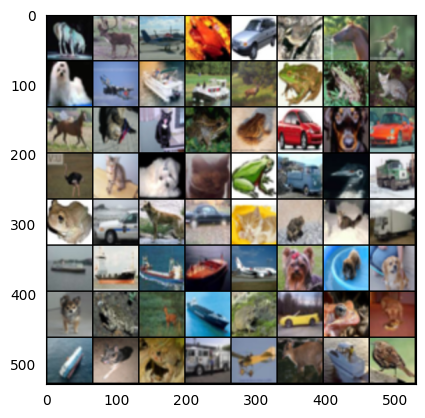

horse deer  plane frog 


In [ ]:
#look at some of the dataset

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in [1]:
  images, labels = next(dataiter)
  # show images
  plt.tick_params(left = False, bottom = False)
  imshow(make_grid(images))
  # print labels
  print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 64, 64])
Image label dimensions: torch.Size([64])
tensor([7, 5, 5, 5, 0, 1, 4, 3, 6, 7])

Validation Set:
Image batch dimensions: torch.Size([64, 3, 64, 64])
Image label dimensions: torch.Size([64])
tensor([9, 6, 1, 8, 1, 0, 7, 9, 9, 6])

Testing Set:
Image batch dimensions: torch.Size([64, 3, 64, 64])
Image label dimensions: torch.Size([64])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])


In [ ]:
##########################
### MODEL
##########################

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [ ]:
torch.manual_seed(RANDOM_SEED)
model = AlexNet(NUM_CLASSES)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [ ]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS, model=model, 
                                      optimizer=optimizer, device=DEVICE, 
                                      train_loader=train_loader, valid_loader=valid_loader, 
                                      logging_interval=50)

#save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/AlexNet trained models/alexnet_model_v2.pt')

Epoch: 001/040 | Batch 0000/0703 | Loss: 2.3041
Epoch: 001/040 | Batch 0050/0703 | Loss: 2.2656
Epoch: 001/040 | Batch 0100/0703 | Loss: 2.0199
Epoch: 001/040 | Batch 0150/0703 | Loss: 1.9349
Epoch: 001/040 | Batch 0200/0703 | Loss: 1.8345
Epoch: 001/040 | Batch 0250/0703 | Loss: 1.6804
Epoch: 001/040 | Batch 0300/0703 | Loss: 1.8714
Epoch: 001/040 | Batch 0350/0703 | Loss: 1.7117
Epoch: 001/040 | Batch 0400/0703 | Loss: 1.7608
Epoch: 001/040 | Batch 0450/0703 | Loss: 1.4076
Epoch: 001/040 | Batch 0500/0703 | Loss: 1.6969
Epoch: 001/040 | Batch 0550/0703 | Loss: 1.6487
Epoch: 001/040 | Batch 0600/0703 | Loss: 1.7234
Epoch: 001/040 | Batch 0650/0703 | Loss: 1.4476
Epoch: 001/040 | Batch 0700/0703 | Loss: 1.6269
***Epoch: 001/040 | Train. Acc.: 42.083% | Loss: 1.515
***Epoch: 001/040 | Valid. Acc.: 42.580% | Loss: 1.520
Time elapsed: 2.38 min
Epoch: 002/040 | Batch 0000/0703 | Loss: 1.6146
Epoch: 002/040 | Batch 0050/0703 | Loss: 1.5225
Epoch: 002/040 | Batch 0100/0703 | Loss: 1.4671
Epo

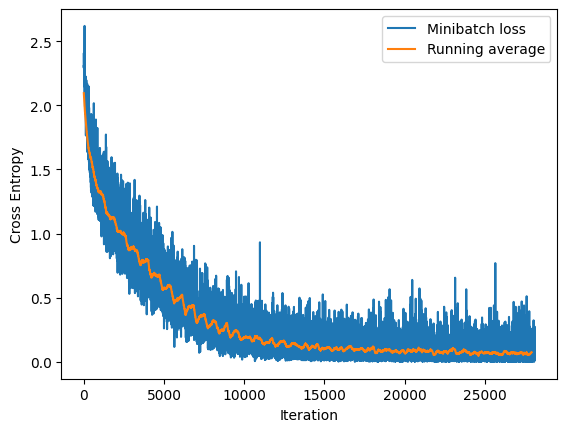

In [ ]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

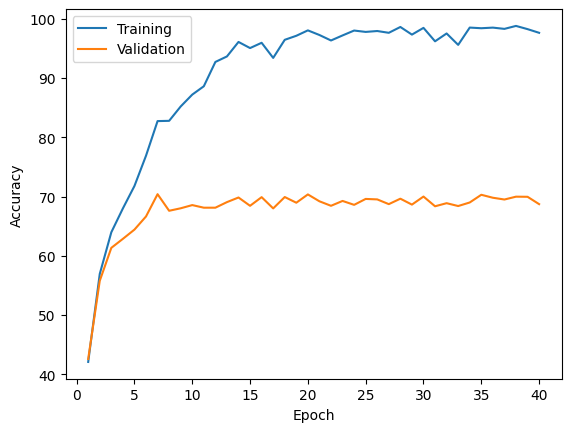

In [ ]:
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 97.64%
Validation ACC: 68.72%
Test ACC: 67.44%
